In [ ]:
## Action: 
## Loading dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, 
    BasicTicker, ColorBar,DataRange1d, PanTool, Range1d, WheelZoomTool, BoxSelectTool)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import pos_tag, pos_tag_sents
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

In [ ]:
pwd

'/content/drive/My Drive/ADM_Final'

In [ ]:
## Action: 
## Loading datasets

path = "/content/drive/My Drive/ADM_Final/"
business = pd.read_csv(path+"yelp_business.csv")
checkin = pd.read_csv(path+"yelp_checkin.csv")
review = pd.read_csv(path+"yelp_review.csv")
tip = pd.read_csv(path+"yelp_tip.csv")

In [ ]:
business.head(3)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...


In [ ]:
checkin.head(3)

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1


In [ ]:
review.head(3)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0


In [ ]:
tip.head(3)

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ


In [ ]:
## Action: 
## Create copies of datasets for redundancy

business_copy = business
checkin_copy = checkin
review_copy = review
tip_copy = tip

## 3.  Data Exploration and Quality Assessment

### 3.1.  Business

In [ ]:
## Action:
## Check shape of dataframe (#rows, #columns)
business.shape

(174567, 13)

In [ ]:
## Action:
## Check distinct count of businesses 
business.business_id.nunique()

174567

In [ ]:
## Action:
## Check for missing values
business.isnull().sum()

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64

** Observation: **
    * A very large number of businesses with no duplication in the dataset
    * Very large number of missing values in neighbourhood and postal_code.
    * It would be wise to remove these columns altogether. 
    * Location of restaurants is a significant attribute and can be accounted for by latitude, longitude, and city
    * Other columns having one missing value each are city, state, latitude, and longitude. 

### 3.2.  Checkin

In [ ]:
## Action:
## Check shape of dataframe (#rows, #columns)
checkin.shape

(3911218, 4)

In [ ]:
## Action:
## Check distinct count of businesses 
checkin.business_id.nunique()

146350

In [ ]:
## Action:
## Check for missing values
checkin.isnull().sum()

business_id    0
weekday        0
hour           0
checkins       0
dtype: int64

### 3.3. Review

In [ ]:
## Action:
## Check shape of dataframe (#rows, #columns)
review.shape

(5261668, 9)

In [ ]:
## Action:
## Check distinct count of reviews 
review.review_id.nunique()

5261668

In [ ]:
## Action:
## Check distinct count of businesses 
review.business_id.nunique()

174567

In [ ]:
## Action:
## Check for missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

### 3.4.  Tip

In [ ]:
## Action:
## Check shape of dataframe (#rows, #columns)
tip.shape

(1098322, 5)

In [ ]:
## Action:
## Check distinct count of businesses 
tip.business_id.nunique()

112365

In [ ]:
## Action:
## Check for missing values
tip.isnull().sum()

text           0
date           0
likes          0
business_id    0
user_id        0
dtype: int64

## 4.  Data Preparation and Sentiment Analysis

### 4.1.  Downsize business data

In [ ]:
## Action:
## 1. Drop businesses which are not open (is_open == 0)
## 2. Drop businesses which are not in restaurant business (categories do not contain the keyword "food")
## 3. Drop businesses which have any missing values (remember there were 5 columns with missing values)
## 4. Create a random stratified sample of restaurants with equal weightage to 'stars' column (distinct count = 9)
## 5. Drop unnecessary columns (neighborhood, address, postal_code, is_open, categories) and reindex

def downsize_business(business):
    business.drop(business[business.is_open == 0].index, inplace = True)
    business.drop(business[~business['categories'].str.lower().str.contains('food')].index, inplace = True)
    business.dropna(axis=0, how='any', inplace = True)
    business1 = business.groupby('stars').apply(lambda x: x.sample(n=20))
    business1.drop(business1.columns[[2, 3, 6, 11, 12]], axis=1, inplace=True)
    business1 = business1.reset_index(drop=True)
    return business1

business1 = downsize_business(business)
business1.head()

,business_id,name,city,state,latitude,longitude,stars,review_count
0,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3
1,2vuAlukfUZf3vbHsexEeDw,"""McDonald's""",Toronto,ON,43.672265,-79.467877,1.0,9
2,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,43
3,kM0RJz-fyNaGk_EH765RKA,"""KFC""",Madison,WI,43.103600,-89.343800,1.0,3
4,u7Q0cxqji35X75C5YWHHPA,"""ARCO ampm""",Las Vegas,NV,36.006095,-115.137480,1.0,8


### 4.2.  Downsize Checkin data

In [ ]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe checkin1 having business ids in temp
## 3. Create a new dataframe checkin2 with aggregation (Business Id - Total count of checkins)

def downsize_checkin(checkin, business1):
    temp = business1['business_id'].tolist()
    checkin1 = checkin[checkin['business_id'].isin(temp)]
    checkin2 = checkin1.groupby('business_id').sum().reset_index()
    return checkin2

checkin2 = downsize_checkin(checkin, business1)
checkin2.head()

,business_id,checkins
0,-3H_6UZGWrfl8XQsm1fBmw,2
1,-EFDz-s9QUWJbFIp16O_3g,4
2,-KqwcJ10CUzl-hEwgwGhUA,58
3,-LMycE26AortJDsbc8oXOg,140
4,-ixX2y0syGy-YfFkJNn3ug,78


In [ ]:
## Naive check to see if any row didn't get aggregated. This should return 0
len(checkin2[checkin2['checkins'] < 1]) 

0

### 4.3.  Merge business and checkin data

In [ ]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe checkin1 having business ids in temp
## 3. Create a new dataframe checkin2 with aggregation (Business Id - Total count of checkins)

def merge_business_checkin(checkin2, business1):
    business_checkin = pd.merge(business1, checkin2, on='business_id', how='left')
    business_checkin.fillna(0)
    return business_checkin

business_checkin = merge_business_checkin(checkin2, business1)
business_checkin.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins
0,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0
1,2vuAlukfUZf3vbHsexEeDw,"""McDonald's""",Toronto,ON,43.672265,-79.467877,1.0,9,61.0
2,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,43,2.0
3,kM0RJz-fyNaGk_EH765RKA,"""KFC""",Madison,WI,43.103600,-89.343800,1.0,3,5.0
4,u7Q0cxqji35X75C5YWHHPA,"""ARCO ampm""",Las Vegas,NV,36.006095,-115.137480,1.0,8,79.0


### 4.4.  Downsize review data

In [ ]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe review1 having business ids in temp and keep only relevant columns
## 3. Create a new dataframe review2 with index resetting (for future operations on this dataset)

def downsize_review(review, business1):
    temp = business1['business_id'].tolist()
    review1 = review[review['business_id'].isin(temp)]
    review1 = review1[['business_id', 'stars', 'text']]
    review2 = review1.reset_index(drop=True)
    return review2

review2 = downsize_review(review, business1)
review2.head()

,business_id,stars,text
0,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...
1,L6R2Op88NkoG1EGxlVvdRQ,4,"A little on the pricey end for baked goods, bu..."
2,tEaW0zgsYihSTjysrpXaWg,4,"I don't do ice cream-ish desserts, pretty much..."
3,HqhiUa-_BiVzFU8YHCd8kA,3,Je ne suis pas trop fan des 3B anjou. Bien que...
4,kgw8nBO9ZMRhukfnJd6bxg,4,As always Chris is friendly and personable! Th...


### 4.5.  Sentiment Analysis - I : Yelp customer reviews

In [ ]:
## Action:

## 1. Clean the text data in review dataset
## 2. Tokenize all text to sentences and then words
## 3. Tag all the words with position tags
## 4. Convert all tags to wrodnet tags
## 5. Lemmatize the words and create synsets
## 6. Compute sentiment score (positive score - negative score)
## 7/ Return a sentiment polarity score: 1 = positive, 0 = negative

#nltk.download('punkt')
 
lemmatizer = WordNetLemmatizer()
  
def convert_tag(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
def clean_text(text):
    text = text.replace("<br />", " ")
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    #text = text.decode("utf-8")
    return text
 
def compute_swn_polarity_score(text):
    sentiment_score = 0.0
    num_tokens = 0
    text = clean_text(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tagged_sentence = pos_tag(word_tokenize(sentence))
        for word, tag in tagged_sentence:
            wn_tag = convert_tag(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
            num_tokens += 1
    # sum greater than 0 => positive sentiment
    if sentiment_score >= 0:
        return 1
    # All other scenarios => negative sentiment
    else:
        return 0

In [ ]:
import nltk
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [ ]:
## Action:
## Create a new column 'polarity' with sentiment polarity as 1 (positive) or 0 (negative)
review2['polarity'] = review2['text'].apply(compute_swn_polarity_score)
review2.head()

,business_id,stars,text,polarity
0,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...,1
1,L6R2Op88NkoG1EGxlVvdRQ,4,"A little on the pricey end for baked goods, bu...",1
2,tEaW0zgsYihSTjysrpXaWg,4,"I don't do ice cream-ish desserts, pretty much...",1
3,HqhiUa-_BiVzFU8YHCd8kA,3,Je ne suis pas trop fan des 3B anjou. Bien que...,0
4,kgw8nBO9ZMRhukfnJd6bxg,4,As always Chris is friendly and personable! Th...,1


In [ ]:
## Action:
## 1. Create a new dataframe review3 by averaging all columns to give 99 distinct rows of business ids 
## 2. Reset index
## 3. Round up the 'stars' and 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment' and 'stars' to 'review_stars'

def transform_review(review2):
    review3 = review2.groupby('business_id').mean().reset_index()
    #review3['stars'].round(2)
    review3['stars'] = review3['stars'].apply(lambda x: round(x,2))
    review3['polarity'] = review3['polarity'].apply(lambda x: round(x,2))
    review3.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    review3.rename(columns={'stars':'review_stars'}, inplace=True)
    return review3
review3 = transform_review(review2)
review3.head()

,business_id,review_stars,net_positive_sentiment_score
0,-3H_6UZGWrfl8XQsm1fBmw,2.43,0.57
1,-EFDz-s9QUWJbFIp16O_3g,2.00,0.67
2,-KqwcJ10CUzl-hEwgwGhUA,1.62,0.25
3,-LMycE26AortJDsbc8oXOg,2.89,0.64
4,-VroyZsX0DDPlkErSw658g,4.00,1.00


In [ ]:
## Action:
## 1. Join business_checkin and review3 dataframces
## 2. Fill any missing values with 0

def merge_business_checkin_review(review3, business_checkin):
    business_checkin_review = pd.merge(business_checkin, review3, on='business_id', how='inner')
    business_checkin_review.fillna(0)
    return business_checkin_review

business_checkin_review = merge_business_checkin_review(review3, business_checkin)
business_checkin_review.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins,review_stars,net_positive_sentiment_score
0,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0,1.00,0.00
1,2vuAlukfUZf3vbHsexEeDw,"""McDonald's""",Toronto,ON,43.672265,-79.467877,1.0,9,61.0,1.11,0.11
2,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,43,2.0,1.09,0.16
3,kM0RJz-fyNaGk_EH765RKA,"""KFC""",Madison,WI,43.103600,-89.343800,1.0,3,5.0,1.00,0.33
4,u7Q0cxqji35X75C5YWHHPA,"""ARCO ampm""",Las Vegas,NV,36.006095,-115.137480,1.0,8,79.0,1.00,0.12


### 4.6.  Downsize Tip Data

In [ ]:
## Action:
## 1. Copy the unique list of business ids in a 'temp' variable
## 2. Create a new dataframe review1 having business ids in temp and keep only relevant columns
## 3. Create a new dataframe review2 with index resetting (for future operations on this dataset)

def downsize_tip(tip, business1):
    temp = business1['business_id'].tolist()
    tip1 = tip[tip['business_id'].isin(temp)]
    tip1 = tip1[['business_id', 'text']]
    tip2 = tip1.reset_index(drop=True)
    return tip2

tip2 = downsize_tip(tip, business1)
tip2.head()

,business_id,text
0,JWDiG0nSsM7GQ9QFRTxU9w,Awesome selection!!
1,tmCLmE3yfILnCC1EwhJ8gA,Voicing additional concerns about this place's...
2,7Nz_04fXn8L-u5L6hyLGvQ,"Their fish sandwiches are back, just in time f..."
3,7Nz_04fXn8L-u5L6hyLGvQ,Mgr. Said all their prices went up today (i.e....
4,1MQQZ2kTiBbN3_hpmGdavw,Larger selection of made-on-site sauces than G...


### 4.7.  Sentiment Analysis - II : Tip Reviews

In [ ]:
tip2['polarity'] = tip2['text'].apply(compute_swn_polarity_score)
tip2.head()

,business_id,text,polarity
0,JWDiG0nSsM7GQ9QFRTxU9w,Awesome selection!!,1
1,tmCLmE3yfILnCC1EwhJ8gA,Voicing additional concerns about this place's...,1
2,7Nz_04fXn8L-u5L6hyLGvQ,"Their fish sandwiches are back, just in time f...",1
3,7Nz_04fXn8L-u5L6hyLGvQ,Mgr. Said all their prices went up today (i.e....,0
4,1MQQZ2kTiBbN3_hpmGdavw,Larger selection of made-on-site sauces than G...,1


In [ ]:
## Action:
## 1. Create a new dataframe tip3 by averaging all columns to give 99 distinct rows of business ids 
## 2. Reset index
## 3. Round up the 'polarity' columns to 2 decimals
## 4. Rename 'polarity' column to 'net_positive_sentiment'

def transform_tip(tip2):
    tip3 = tip2.groupby('business_id').mean().reset_index()
    tip3['polarity'] = tip3['polarity'].apply(lambda x: round(x,2))
    tip3.rename(columns={'polarity':'net_positive_sentiment_score'}, inplace=True)
    return tip3

tip3 = transform_tip(tip2)
tip3.head()

,business_id,net_positive_sentiment_score
0,-3H_6UZGWrfl8XQsm1fBmw,0.67
1,-KqwcJ10CUzl-hEwgwGhUA,1.00
2,-LMycE26AortJDsbc8oXOg,0.90
3,-ixX2y0syGy-YfFkJNn3ug,1.00
4,0xvdC8F0HmFpAFkJk6nXLg,0.75


In [ ]:
## Action:
## 1. Join business_checkin_review and tip3 dataframes
## 2. Fill any missing values with 0

def merge_business_checkin_review_tip(tip3, business_checkin_review):
    business_checkin_review_tip = pd.merge(business_checkin_review, tip3, on='business_id', how='left')
    business_checkin_review_tip.rename(columns={'net_positive_sentiment_score_x':
                                                'net_positive_sentiment_score_review'}, inplace=True)
    business_checkin_review_tip.rename(columns={'net_positive_sentiment_score_y':
                                                'net_positive_sentiment_score_tip'}, inplace=True)
    return business_checkin_review_tip

business_checkin_review_tip = merge_business_checkin_review_tip(tip3, business_checkin_review)
business_checkin_review_tip.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,checkins,review_stars,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
0,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,3,4.0,1.00,0.00,0.0
1,2vuAlukfUZf3vbHsexEeDw,"""McDonald's""",Toronto,ON,43.672265,-79.467877,1.0,9,61.0,1.11,0.11,0.5
2,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,43,2.0,1.09,0.16,1.0
3,kM0RJz-fyNaGk_EH765RKA,"""KFC""",Madison,WI,43.103600,-89.343800,1.0,3,5.0,1.00,0.33,0.0
4,u7Q0cxqji35X75C5YWHHPA,"""ARCO ampm""",Las Vegas,NV,36.006095,-115.137480,1.0,8,79.0,1.00,0.12,0.0


In [ ]:
data = business_checkin_review_tip
data = data.dropna()
len(data)

133

## 5. Exploratory Data Analysis

### 5.2.  Correlation Heatmap

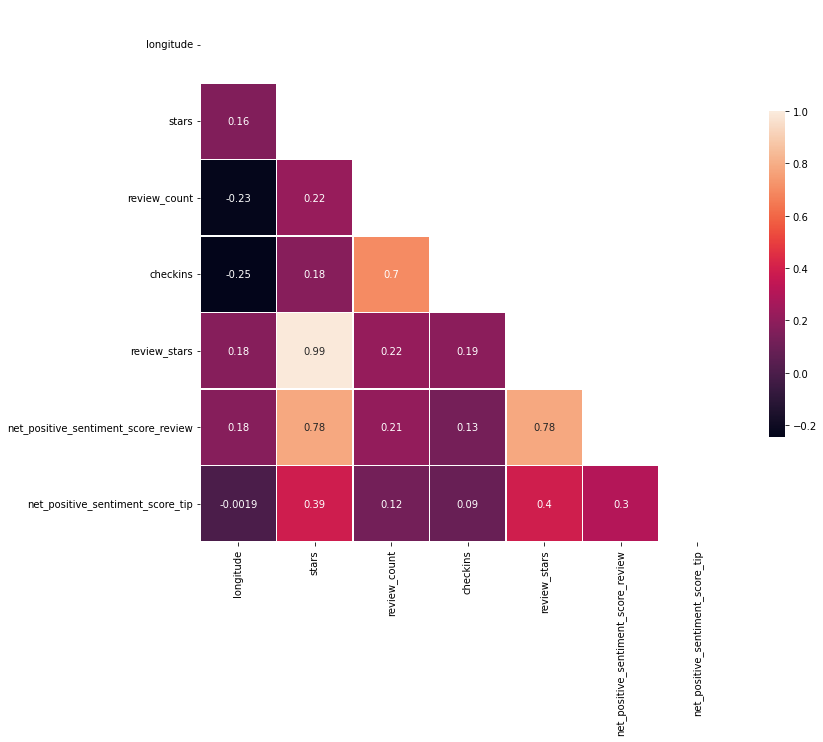

In [ ]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

** Observation: **

    * stars has high correlation with review_stars and net_positive_sentiment_score_review
    * review_count and checkins are also highly correlated. So we should use only one of these in the model
    * review_stars and net_positive_sentiment_score_review also has a high correlation

So to sum up, we need to eliminate review_stars. Also, between review_count and checkins, I will eliminate review_count as it is already accounted for in the computation of net_positive_sentiment_score_review

** Ultimately, I shall move ahead with following features **

    * net_positive_sentiment_score_review
    * net_positive_sentiment_score_tip
    * checkins

In [ ]:
data.drop(data.columns[[7, 9]], axis=1, inplace=True)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,business_id,name,city,state,latitude,longitude,stars,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
0,QcTpYpgEYSZ6vPGgz3LiDQ,"""Subway""",Scarborough,ON,43.772917,-79.321447,1.0,4.0,0.00,0.0
1,2vuAlukfUZf3vbHsexEeDw,"""McDonald's""",Toronto,ON,43.672265,-79.467877,1.0,61.0,0.11,0.5
2,iYQPfLcPQXiYi-kycrm2rw,"""Sparkletts Water""",Las Vegas,NV,36.128999,-115.196301,1.0,2.0,0.16,1.0
3,kM0RJz-fyNaGk_EH765RKA,"""KFC""",Madison,WI,43.103600,-89.343800,1.0,5.0,0.33,0.0
4,u7Q0cxqji35X75C5YWHHPA,"""ARCO ampm""",Las Vegas,NV,36.006095,-115.137480,1.0,79.0,0.12,0.0


### 5.3.  Restaurant Category Creation

##### Awesome     ::     stars >= 3.5
##### Average     ::     stars 2.0 < x < 3.5
##### Not really  ::     stars <= 2.0

In [ ]:
## Action:
## Categorize all restaurants

def categorize(data):
    if data['stars'] >= 3.5:
        return 'Awesome'
    elif data['stars'] <= 2.0:
        return 'Not Really'
    else:
        return 'Average'
    
data['restaurant_category'] = data.apply(categorize, axis=1)

data.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,business_id,name,city,state,latitude,longitude,stars,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip,restaurant_category
170,o1bTHnU2JK4AM5C3UE7jFA,"""Cha Do Raku""",Montréal,QC,45.526407,-73.583155,5.0,3.0,0.78,1.00,Awesome
172,Fv9skIAikwPKkh7sHpHVug,"""Water R Us""",Las Vegas,NV,36.123875,-115.279439,5.0,32.0,0.73,1.00,Awesome
174,6GLsLSjnALxD0oflLFy3NA,"""Boucherie Viandal""",Verdun,QC,45.462898,-73.571098,5.0,5.0,0.88,0.50,Awesome
176,jRxLnJ9my31Re_O2MvQGhw,"""The Tasty Bowl Subs N Such""",Charlotte,NC,35.132832,-80.952928,5.0,67.0,0.64,0.80,Awesome
177,wsgWLUX6ZVBEBQglZRVt2w,"""Linda's Superette""",Cleveland,OH,41.490816,-81.709332,5.0,271.0,0.50,0.57,Awesome


### 5.4.  Effect of net_positive_sentiment_score_review on Restaurant_Category (Star Rating)

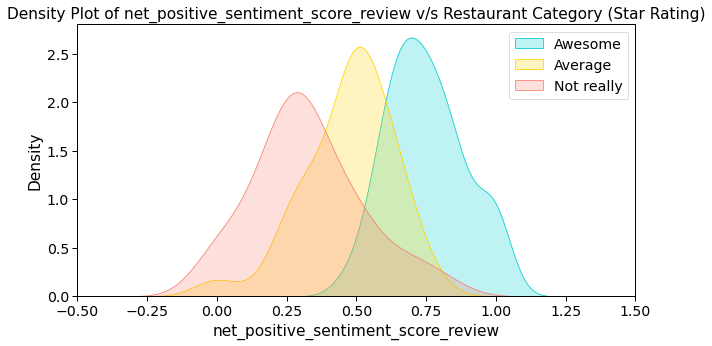

In [ ]:
plt.figure(figsize=(10,5))
sns.set_context("paper", font_scale=1.6)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Awesome"], 
            color="darkturquoise", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Average"], 
            color="gold", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_review"][data.restaurant_category == "Not Really"], 
            color="salmon", shade=True)
plt.xlim(-0.5,1.5)
plt.legend(['Awesome', 'Average', 'Not really'])
plt.title('Density Plot of net_positive_sentiment_score_review v/s Restaurant Category (Star Rating)')
plt.show()

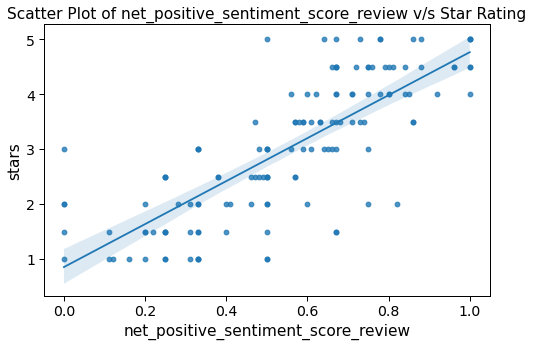

In [ ]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)
sns.regplot(x=data["net_positive_sentiment_score_review"], y=data["stars"])
plt.title('Scatter Plot of net_positive_sentiment_score_review v/s Star Rating')
plt.show()

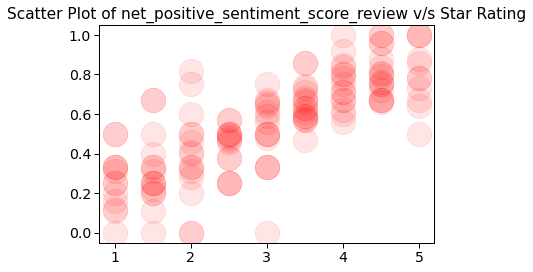

In [ ]:
plt.title('Scatter Plot of net_positive_sentiment_score_review v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data['net_positive_sentiment_score_review'], s=600, c="red", alpha=0.1)

** Observation: **
    * Star Rating (restaurant_category) has a strong linear relationship with net_positive_sentiment_score_review
    * This was intuitive but since I computed the score myself via sentiment analysis this is a strong evidence 
        that the sentiment analysis was rightly done

### 5.5.  Effect of net_positive_sentiment_score_tip on Restaurant_Category (Star Rating)

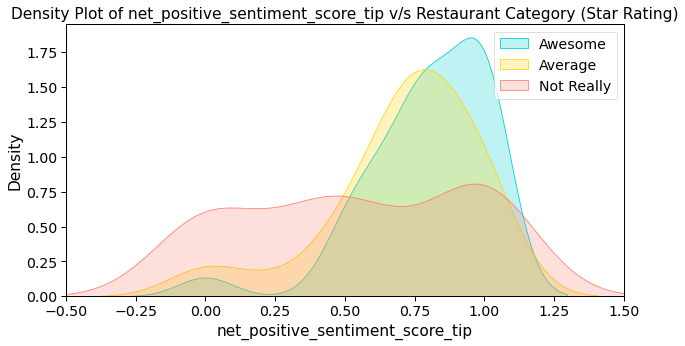

In [ ]:
plt.figure(figsize=(10,5))
sns.set_context("paper", font_scale=1.6)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Awesome"], 
            color="darkturquoise", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Average"], 
            color="gold", shade=True)
sns.kdeplot(data["net_positive_sentiment_score_tip"][data.restaurant_category == "Not Really"], 
            color="salmon", shade=True)
plt.xlim(-0.5,1.5)
plt.legend(['Awesome', 'Average', 'Not Really'])
plt.title('Density Plot of net_positive_sentiment_score_tip v/s Restaurant Category (Star Rating)')
plt.show()

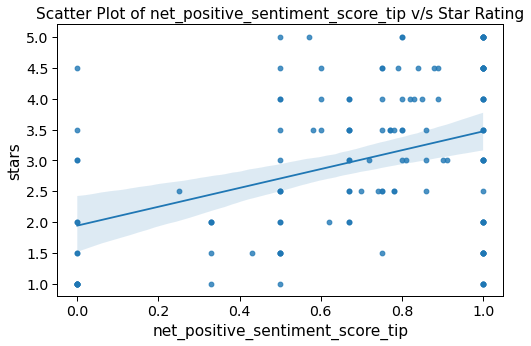

In [ ]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)

sns.regplot(x=data["net_positive_sentiment_score_tip"], y=data["stars"])
plt.title('Scatter Plot of net_positive_sentiment_score_tip v/s Star Rating')
plt.show()

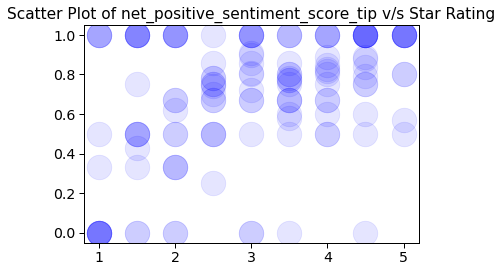

In [ ]:
plt.title('Scatter Plot of net_positive_sentiment_score_tip v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data['net_positive_sentiment_score_tip'], s=600, c="blue", alpha=0.1)

** Observation: **

    * Star Rating (restaurant_category) has a weak linear relationship with net_positive_sentiment_score_tip. 
    * This is interesting and has two explanations. 
        * One is that the sentiment analysis of tip reviews was not accurate enough
        * Two which is more of a logical fact that a customer is more likely to give reviews while shelling out tips
            when he / she is impressed with the restaurant's service. Therefore, it seems like this is a 
            biased / unbalanced attribute!

### 5.6.  Effect of number of checkins on Restaurant_Category (Star Rating)

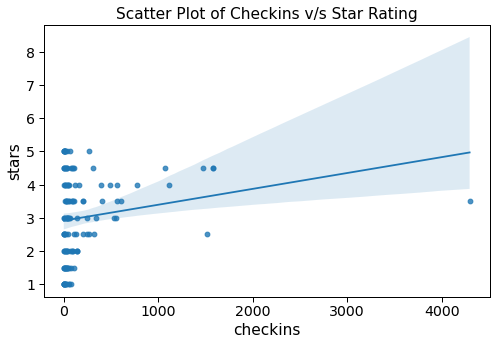

In [ ]:
plt.figure(figsize=(8,5))
sns.set_context("paper", font_scale=1.6)
sns.regplot(x=data["checkins"], y=data["stars"])
plt.title('Scatter Plot of Checkins v/s Star Rating')
plt.show()

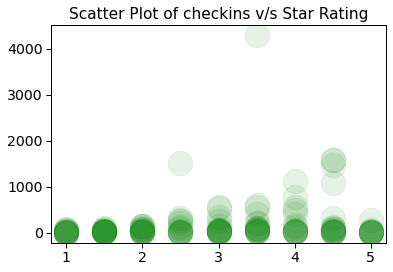

In [ ]:
plt.title('Scatter Plot of checkins v/s Star Rating')
sns.set_context("paper", font_scale=1.6)
plt.scatter(data['stars'], data['checkins'], s=600, c="green", alpha=0.1)

** Observation: **
    * Star Rating (restaurant_category) seem to have a weak relationship with number of checkins
    * Slight indication that average and high rating restaurants have a high number of checkins
        * Again this is interesting and has an explanation. Most average and high rating restaurants 
            give out discounts or deals upon mandatory checkins to boost customer footfalls!

### 5.7.  Compare all three effects

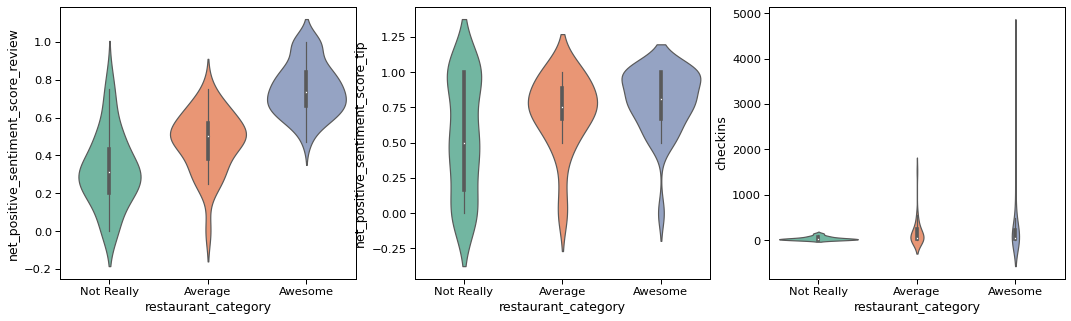

In [ ]:
plt.figure(figsize=(18,5))
sns.set_context("paper", font_scale=1.3)
plt.subplot(1,3,1)
sns.violinplot(x='restaurant_category',y='net_positive_sentiment_score_review',data=data, shade = True, 
               palette="Set2")
plt.subplot(1,3,2)
sns.violinplot(x='restaurant_category',y='net_positive_sentiment_score_tip',data=data, shade = True, palette="Set2")
plt.subplot(1,3,3)
sns.violinplot(x='restaurant_category',y='checkins',data=data, shade = True, palette="Set2")

## 6.  Machine Learning and Prediction

### 6.1.  Create test and training datasets

In [ ]:
final_data = data[['business_id', 'restaurant_category', 'checkins', 'net_positive_sentiment_score_review', 
                  'net_positive_sentiment_score_tip']]
final_data.head()

,business_id,restaurant_category,checkins,net_positive_sentiment_score_review,net_positive_sentiment_score_tip
0,QcTpYpgEYSZ6vPGgz3LiDQ,Not Really,4.0,0.00,0.0
1,2vuAlukfUZf3vbHsexEeDw,Not Really,61.0,0.11,0.5
2,iYQPfLcPQXiYi-kycrm2rw,Not Really,2.0,0.16,1.0
3,kM0RJz-fyNaGk_EH765RKA,Not Really,5.0,0.33,0.0
4,u7Q0cxqji35X75C5YWHHPA,Not Really,79.0,0.12,0.0


In [ ]:
## Action:
## Scaling the features

X = final_data[['checkins', 'net_positive_sentiment_score_review', 'net_positive_sentiment_score_tip']]
y = final_data[['restaurant_category']].values.ravel()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
classifiers = []
accuracies = []

### 6.2.  Support Vector Machines

In [ ]:
clf = svm.SVC(kernel = 'rbf', C = 100) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('svm.SVC')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.775


### 6.3.  Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth = 5) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('DecisionTreeClassifier')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.7


### 6.4.  Logistic Regression

In [ ]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('LogisticRegression')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.825


### 6.5.  Gaussian Naive Bayes

In [ ]:
clf = GaussianNB() 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('GaussianNB')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.7


### 6.6.  K Neighbors

In [ ]:
clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(round(accuracy, 4))

0.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


([<matplotlib.axis.XTick at 0x7f50708cce90>,
 <a list of 10 Text major ticklabel objects>)

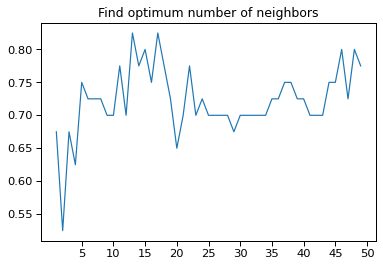

In [ ]:
l=list(range(1,50))
a=pd.Series()
x=[5,10,15,20,25,30,35,40,45,50]
for i in l:
    clf = KNeighborsClassifier(n_neighbors=i) 
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    a = a.append(pd.Series(accuracy_score(pred, y_test)))
plt.title('Find optimum number of neighbors')
plt.plot(l, a)
plt.xticks(x)

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 3)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
classifiers.append('KNeighborsClassifier')
accuracies.append(accuracy)
print(round(accuracy, 4))

0.675


### 6.7.  Model Comparison

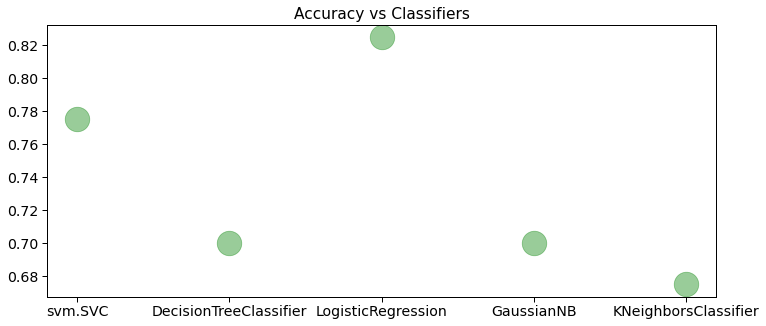

In [ ]:
plt.figure(figsize=(12,5))
sns.set_context("paper", font_scale=1.6)
plt.scatter(classifiers, accuracies, s=600, c="green", alpha=0.4)
plt.title('Accuracy vs Classifiers')
plt.show()

In [ ]:
## Prediction on entire dataset based on the KNeighborsClassifier model

preds = clf.predict(X)
data['predicted_restaurant_category'] = preds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Predicted

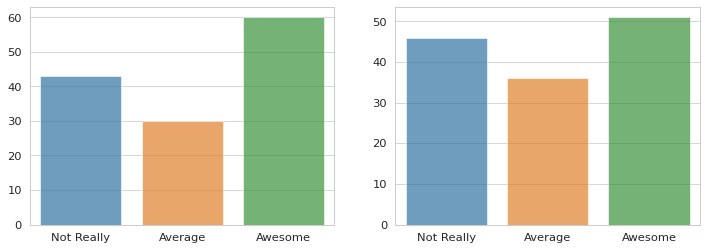

In [ ]:
x = ['Not Really', 'Average', 'Awesome']
y1 = len(data[data.restaurant_category == 'Not Really'])
y2 = len(data[data.restaurant_category == 'Average'])
y3 = len(data[data.restaurant_category == 'Awesome'])
y1_pred = len(data[data.predicted_restaurant_category == 'Not Really'])
y2_pred = len(data[data.predicted_restaurant_category == 'Average'])
y3_pred = len(data[data.predicted_restaurant_category == 'Awesome'])
y = [y1, y2, y3]
y_pred = [y1_pred, y2_pred, y3_pred]

plt.figure(figsize=(12,4))
sns.set_context("paper", font_scale=1.3)
sns.set_style("whitegrid")
plt.subplot(1,2,1)
sns.barplot(x=x, y=y, data=data, alpha = 0.7)
plt.subplot(1,2,2)
sns.barplot(x=x, y=y_pred, data=data, alpha = 0.7)